In [98]:
import random
import numpy as np
from deap import base, creator, tools, algorithms
import networkx as nx
import matplotlib.pyplot as plt
import copy
import elitism
import json

In [99]:
with open('./real_data.json', 'r') as file:
    data = json.load(file)
data = data[0]
data

{'stations': {'Златоуст (1)': ['0', '38', '38', '25', '29', '7', '10'],
  'Кыштым (2)': ['26', '0', '7', '34', '20', '27', '35'],
  'Миасс (3)': ['15', '5', '0', '27', '16', '31', '24'],
  'Муслюмово (4)': ['12', '39', '1', '0', '2', '14', '20'],
  'Челябинск (5)': ['38', '38', '1', '28', '0', '33', '14'],
  'Полетаево (6)': ['21', '27', '24', '9', '1', '0', '3'],
  'Еманжелинск (7)': ['9', '3', '23', '25', '32', '37', '0']},
 'full_timetable': {'853': {'route': ['1', '3', '2'],
   'free_carriage': ['21', '21'],
   'timetable': ['02:00 - 02:38', '04:48 - 06:11', '13:35 - 13:58']},
  '801': {'route': ['1', '3', '2'],
   'free_carriage': ['34', '10'],
   'timetable': ['03:24 - 04:22', '06:32 - 07:06', '14:30 - 15:39']},
  '563': {'route': ['1', '3', '6', '5', '4'],
   'free_carriage': ['33', '20', '35', '3'],
   'timetable': ['03:43 - 04:26',
    '06:36 - 08:04',
    '11:42 - 11:59',
    '13:21 - 14:32',
    '16:42 - 17:34']},
  '182': {'route': ['1', '3', '6', '5', '7'],
   'free_carria

In [100]:
stations = [list(map(int, x)) for x in data['stations'].values()]
stations

[[0, 38, 38, 25, 29, 7, 10],
 [26, 0, 7, 34, 20, 27, 35],
 [15, 5, 0, 27, 16, 31, 24],
 [12, 39, 1, 0, 2, 14, 20],
 [38, 38, 1, 28, 0, 33, 14],
 [21, 27, 24, 9, 1, 0, 3],
 [9, 3, 23, 25, 32, 37, 0]]

In [101]:
trains = [x for x in data['full_timetable'].values()]
trains

[{'route': ['1', '3', '2'],
  'free_carriage': ['21', '21'],
  'timetable': ['02:00 - 02:38', '04:48 - 06:11', '13:35 - 13:58']},
 {'route': ['1', '3', '2'],
  'free_carriage': ['34', '10'],
  'timetable': ['03:24 - 04:22', '06:32 - 07:06', '14:30 - 15:39']},
 {'route': ['1', '3', '6', '5', '4'],
  'free_carriage': ['33', '20', '35', '3'],
  'timetable': ['03:43 - 04:26',
   '06:36 - 08:04',
   '11:42 - 11:59',
   '13:21 - 14:32',
   '16:42 - 17:34']},
 {'route': ['1', '3', '6', '5', '7'],
  'free_carriage': ['15', '18', '13', '36'],
  'timetable': ['02:44 - 03:14',
   '05:24 - 05:56',
   '09:34 - 11:00',
   '12:22 - 13:05',
   '15:43 - 16:34']},
 {'route': ['1', '3', '6', '5', '7'],
  'free_carriage': ['18', '1', '13', '21'],
  'timetable': ['03:23 - 03:48',
   '05:58 - 07:21',
   '10:59 - 11:20',
   '12:42 - 13:03',
   '15:41 - 16:15']},
 {'route': ['2', '3', '1'],
  'free_carriage': ['8', '33'],
  'timetable': ['01:00 - 02:01', '09:25 - 10:35', '12:45 - 13:00']},
 {'route': ['2', '3

In [102]:
for train in trains:
    train['free_carriage'].append(0)

In [103]:
timetable = ['02:44 - 03:14',
   '05:24 - 05:56',
   '09:34 - 11:00',
   '12:22 - 13:05',
   '23:43 - 00:34']

In [104]:
def convert_train_to_time_list(train_list):
    train_by_time = []
    for train_id in range(len(train_list)):
        time_list = train_list[train_id]['timetable']

        for i, time in enumerate(time_list):
            before_after = time.split('-')  # [05:24, 05:56]

            for j, rout_part in enumerate(before_after):
                free_carriage = int(train_list[train_id]['free_carriage'][i]) if j == 1 else None
                free_carriage = None if free_carriage == 0 else free_carriage
                hour, minut = [int(x) for x in rout_part.split(':')]
                new_t = hour * 100 + minut
                if i > 0 and train_by_time[-1]['time'] > new_t:
                    new_t *= 1000
                
                train_by_time.append({
                    'id': train_id, 
                    'time': new_t,
                    'st': int(train_list[train_id]['route'][i]), 
                    'free_carriage': free_carriage
                })
    return train_by_time

In [105]:
train_to_time = convert_train_to_time_list(trains)
train_to_time = sorted(train_to_time, key = lambda x: x['time'])
train_to_time

[{'id': 5, 'time': 100, 'st': 2, 'free_carriage': None},
 {'id': 8, 'time': 131, 'st': 2, 'free_carriage': None},
 {'id': 10, 'time': 142, 'st': 2, 'free_carriage': None},
 {'id': 7, 'time': 148, 'st': 2, 'free_carriage': None},
 {'id': 0, 'time': 200, 'st': 1, 'free_carriage': None},
 {'id': 6, 'time': 200, 'st': 2, 'free_carriage': None},
 {'id': 11, 'time': 200, 'st': 3, 'free_carriage': None},
 {'id': 14, 'time': 200, 'st': 4, 'free_carriage': None},
 {'id': 5, 'time': 201, 'st': 2, 'free_carriage': 8},
 {'id': 7, 'time': 210, 'st': 2, 'free_carriage': 22},
 {'id': 14, 'time': 221, 'st': 4, 'free_carriage': 18},
 {'id': 6, 'time': 233, 'st': 2, 'free_carriage': 12},
 {'id': 0, 'time': 238, 'st': 1, 'free_carriage': 21},
 {'id': 3, 'time': 244, 'st': 1, 'free_carriage': None},
 {'id': 9, 'time': 251, 'st': 2, 'free_carriage': None},
 {'id': 8, 'time': 301, 'st': 2, 'free_carriage': 26},
 {'id': 11, 'time': 301, 'st': 3, 'free_carriage': 23},
 {'id': 10, 'time': 303, 'st': 2, 'free_c

In [106]:
train_onboard_main = [[0] * len(stations) for _ in range(len(data['full_timetable']))]
train_onboard_main

[[0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0]]

In [107]:
HROM_LENGHT = sum([1 for x in train_to_time if x['free_carriage'] is not None])


# константы генетического алгоритма
POPULATION_SIZE = 4   # количество индивидуумов в популяции
P_CROSSOVER = 0.9       # вероятность скрещивания
P_MUTATION = 0.2        # вероятность мутации индивидуума
MAX_GENERATIONS = 14    # максимальное количество поколений
HALL_OF_FAME_SIZE = 1
INDIVID_SIZE = len(stations)

MAX_INDIVID = max([int(y) for x in [i['free_carriage'] for i in trains] for y in x])

RANDOM_SEED = 42
random.seed(RANDOM_SEED)

In [108]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, Dropout, Flatten, LayerNormalization
import keras

In [109]:
TRAIN_INTERVAL = 2

first_count = len(stations) * 3 + len(stations) * TRAIN_INTERVAL + TRAIN_INTERVAL

model = keras.Sequential(
    [
        Input(shape=(first_count,), name='digits'),
        LayerNormalization(axis=1),
        Dense(first_count, activation="relu"),
        # Dropout(0.2),
        # Dense(first_count // 2, activation="relu"),
        Dense(first_count // 2, activation="relu"),
        # Dropout(0.2),
        Dense(len(stations), activation='relu'),
    ]
)

In [110]:

import tensorflow as tf
optimiser = tf.keras.optimizers.RMSprop()
model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

model.build()
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_normalization_3 (Lay  (None, 37)                74        
 erNormalization)                                                
                                                                 
 dense_9 (Dense)             (None, 37)                1406      
                                                                 
 dense_10 (Dense)            (None, 18)                684       
                                                                 
 dense_11 (Dense)            (None, 7)                 133       
                                                                 
Total params: 2297 (8.97 KB)
Trainable params: 2297 (8.97 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [111]:
for layer in model.layers:
    print(layer.get_weights()[0].shape)

(37,)
(37, 37)
(37, 18)
(18, 7)


In [112]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

In [113]:
def create_individ(count):
    res = np.random.rand(count) * 2 - 1
    return creator.Individual(res)

In [114]:
toolbox = base.Toolbox()
toolbox.register("individualCreator", create_individ, model.count_params())
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)

In [115]:
population = toolbox.populationCreator(n=POPULATION_SIZE)
population[0]

[-0.3377775679330881,
 -0.7149418296483419,
 -0.8278629109808227,
 -0.9720081527541795,
 0.5600727533040624,
 0.5518136407008223,
 -0.7290592477054612,
 -0.4943793374503158,
 -0.14405076600687772,
 -0.028346304950880308,
 -0.3441035921605047,
 0.3285155380338962,
 -0.10794491468971223,
 -0.842230022443468,
 -0.9380372244269188,
 0.28416281574258595,
 -0.15315971805033368,
 -0.5924371129215324,
 0.8405271805093428,
 -0.6050557048962109,
 0.6954335267769733,
 0.1517615976067339,
 -0.5233244328314206,
 -0.7962089740286931,
 -0.33880705499224684,
 -0.07608447433461252,
 -0.2382371260197027,
 0.8323053848104385,
 -0.8131300081210029,
 -0.29014912016575,
 0.9860652429349701,
 -0.5823717549940319,
 -0.4328803892748141,
 0.8741323526993987,
 -0.49230849600330173,
 -0.702398539346242,
 0.622879870714103,
 0.15344645927164047,
 -0.055205448345760466,
 -0.7394620562243766,
 -0.7173205459539282,
 -0.5663380037702754,
 -0.005404929037701178,
 -0.8994716057416687,
 0.4817055326109898,
 -0.2192441750

In [116]:
def get_train_leave(time, st, count):
    res = []
    for train in train_to_time:
        if train['time'] > time and train['st'] == st and train['free_carriage'] is not None:
            res.append(train['free_carriage'])

        if len(res) == count:
            return res
    
    i = len(res)
    
    for _ in range(i, count):
        res.append(0)
    return res


def get_train_comes(time, st, count, train_onboard):
    res = []
    for train in train_to_time:
        if train['time'] > time and train['st'] == st and train['free_carriage'] is not None:
            res.extend(train_onboard[train['id']])
        
        if len(res) == count * len(stations):
            return res

    i = len(res) // len(stations)
    ln = len(stations)
    
    for _ in range(i, count):
        res.extend([0] * len(stations))
    return res

In [117]:
def get_total_import(new_stations):
    column_sums = []
    for j in range(len(new_stations)):
        column_sum = 0
        for i in range(len(new_stations)):
            column_sum += new_stations[i][j]
        column_sums.append(column_sum)
    return column_sums

In [118]:
get_total_import(stations)

[121, 150, 94, 148, 100, 149, 106]

In [119]:
PENALTY_COST = 200

def shedule_cost(individual, model):
    individ = np.array(copy.deepcopy(individual))
    # print(individ[:5])
    train_onboard = copy.deepcopy(train_onboard_main)
    current_cost = 0
    penalty_count = 0
    new_stations = copy.deepcopy(stations)

    for st in new_stations:  # добавляем время простоя каждого вагона
        st.extend([0] * len(stations))

    # print(new_stations)
    sp_ranges = []
    prev = 0
    for lay in model.get_weights():
        prev += np.prod(lay.shape)
        sp_ranges.append(prev)

    ws = np.split(individ, sp_ranges[:-1])
    model.set_weights([w.reshape(lay.shape) for w,lay in zip(ws, model.get_weights())])


    for i in range(len(train_to_time)):
        train = train_to_time[i]
        time = train['time']
        station = train['st'] - 1
        if train['free_carriage'] is None:  # если было прибытие поезда
            for vagon_type in range(len(new_stations)):
                if vagon_type != station:  # если вагоны приехали не сюда, то считаем
                    new_stations[station][vagon_type] += train_onboard[train['id']][vagon_type]
                train_onboard[train['id']][vagon_type] = 0
            continue
        
        # если было отбытие поезда
        # print(new_stations[station][:len(new_stations)])
        enter = copy.deepcopy(new_stations[station][:len(new_stations)])
        enter += [sum(st[:len(new_stations)]) for st in new_stations]
        enter += get_total_import(new_stations)

        # print(len(enter))
        
        enter += get_train_comes(time, station, TRAIN_INTERVAL, train_onboard)
        # print(len(enter))

        enter += get_train_leave(time, station, TRAIN_INTERVAL)

        # print(enter)

        pred = model.predict([enter])[0]
        # print(pred)
        # vagon_type = np.argmax(pred)
        vagon_priority = []

        onboard_val = 0
        for _ in range(len(pred)):
            curr_id = np.argmax(pred)
            # print(curr_id)
            avaiable_val = min(train['free_carriage'] - onboard_val, new_stations[station][curr_id])

            if avaiable_val == new_stations[station][curr_id]:  # сбрасываем счетчик времени, если уехали все вагоны этого типа
                new_stations[station][curr_id + len(stations)] = 0

            onboard_val += avaiable_val
            if onboard_val > train['free_carriage']:
                break

            new_stations[station][curr_id] -= avaiable_val
            train_onboard[train['id']][curr_id] += avaiable_val
            # vagon_priority.append(np.argmax(pred))

            pred[curr_id] = -1

        # print(new_stations[station])
        # print(train_onboard[train['id']], train['free_carriage'])


        # print(vagon_type, train)

        # avaiable_val = min(train['free_carriage'], new_stations[station][vagon_type])

        # if avaiable_val == new_stations[station][vagon_type]:  # сбрасываем счетчик времени, если уехали все вагоны этого типа
        #     new_stations[station][vagon_type + len(stations)] = 0

        # new_stations[station][vagon_type] -= avaiable_val
        # train_onboard[train['id']][vagon_type] += avaiable_val


        for vagon_type in range(len(new_stations)):
            if new_stations[station][vagon_type] != 0:
                new_stations[station][vagon_type + len(stations)] += 1

        row_sums = []
        for row in new_stations:
            row_sum = float(sum(row[-len(new_stations):])) / float(len(new_stations))
            row_sums.append(row_sum)

        
        # print(row_sums)

        current_cost += sum(row_sums)





    # model.set_weights(individual)
    return current_cost,

In [120]:
shedule_cost(population[0], model)

1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 35ms/step


(303.4285714285714,)

In [121]:
shedule_cost(population[1], model)

1/1 [==============================] - 0s 27ms/step


(338.42857142857133,)

In [122]:
def mate(ind1, ind2):
    ind1, ind2 = tools.cxBlend(ind1, ind2, 0.5)
    return ind1, ind2

def mut(individual, indpb):           
    individual = tools.mutPolynomialBounded(individual, low=-1, up=1, eta=20, indpb=indpb)
    return individual,

In [123]:
toolbox.register("evaluate", shedule_cost, model=model)
toolbox.register("select", tools.selTournament, tournsize=2)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutPolynomialBounded, low=-1, up=1, eta=20, indpb=1.0/HROM_LENGHT)

In [124]:
hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

In [125]:
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("min", np.min)
stats.register("avg", np.mean)

In [126]:
population, logbook = elitism.eaSimpleWithElitism(population, toolbox,
                                        cxpb=P_CROSSOVER,
                                        mutpb=P_MUTATION,
                                        ngen=MAX_GENERATIONS,
                                        halloffame=hof,
                                        stats=stats,
                                        verbose=True)

1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 26ms/step
gen	nevals	min    	avg    
0  	4     	303.429	333.357
1/1 [==============================] - 0s 27ms/step
1  	2     	303.429	325.679
1/1 [==============================] - 0s 26ms/step
2  	2     	303.429	309.071
1/1 [==============================] - 0s 27ms/step
3  	2     	303.429	303.429
1/1 [==============================] - 0s 28ms/step
4  	2     	303.429	303.429
1/1 [==============================] - 0s 30ms/step
5  	3     	303.429	303.429
1/1 [==============================] - 0s 27ms/step
6  	2     	303.429	303.429
1/1 [==============================] - 0s 27ms/step
7  	2     	303.429	303.429
1/1 [==============================] - 0s 29ms/step
8  	2     	303.429	303.429
1/1 [==============================] - 0s 30ms/step
9  	2     	303.429	303.429
1/1 [==============================] - 0s 27ms/step
10 	2     	303.429	303.429
11 	0     	303.429	303.429
1/1 [==============================] - 0s 27ms/step
12 	2     	303.429	303.42

In [127]:
maxFitnessValues, meanFitnessValues = logbook.select("min", "avg")

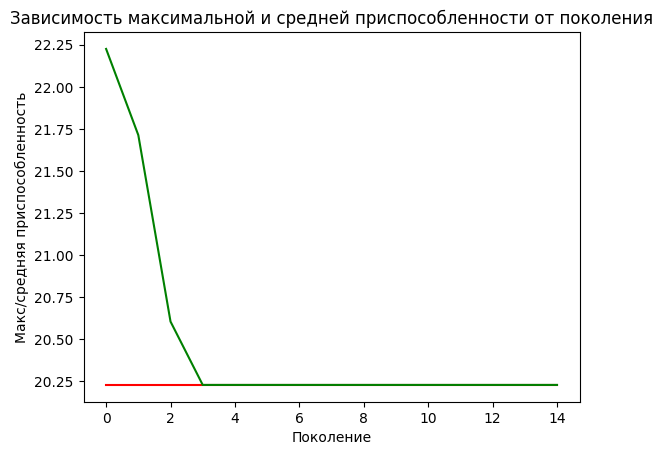

In [128]:
plt.plot(np.array(maxFitnessValues)/len(trains), color='red')
plt.plot(np.array(meanFitnessValues)/len(trains), color='green')
plt.xlabel('Поколение')
plt.ylabel('Макс/средняя приспособленность')
plt.title('Зависимость максимальной и средней приспособленности от поколения')
 
plt.show()

In [129]:
best_shedule = hof.items[0]
best_shedule

[-0.3377775679330881,
 -0.7149418296483419,
 -0.8278629109808227,
 -0.9720081527541795,
 0.5600727533040624,
 0.5518136407008223,
 -0.7290592477054612,
 -0.4943793374503158,
 -0.14405076600687772,
 -0.028346304950880308,
 -0.3441035921605047,
 0.3285155380338962,
 -0.10794491468971223,
 -0.842230022443468,
 -0.9380372244269188,
 0.28416281574258595,
 -0.15315971805033368,
 -0.5924371129215324,
 0.8405271805093428,
 -0.6050557048962109,
 0.6954335267769733,
 0.1517615976067339,
 -0.5233244328314206,
 -0.7962089740286931,
 -0.33880705499224684,
 -0.07608447433461252,
 -0.2382371260197027,
 0.8323053848104385,
 -0.8131300081210029,
 -0.29014912016575,
 0.9860652429349701,
 -0.5823717549940319,
 -0.4328803892748141,
 0.8741323526993987,
 -0.49230849600330173,
 -0.702398539346242,
 0.622879870714103,
 0.15344645927164047,
 -0.055205448345760466,
 -0.7394620562243766,
 -0.7173205459539282,
 -0.5663380037702754,
 -0.005404929037701178,
 -0.8994716057416687,
 0.4817055326109898,
 -0.2192441750

In [130]:
sp_ranges = []
prev = 0
for lay in model.get_weights():
    prev += np.prod(lay.shape)
    sp_ranges.append(prev)

ws = np.split(best_shedule, sp_ranges[:-1])
model.set_weights([w.reshape(lay.shape) for w,lay in zip(ws, model.get_weights())])

In [131]:
model.save(f'pop_{POPULATION_SIZE}_gen_{MAX_GENERATIONS}.keras')

In [141]:
PENALTY_COST = 200

def shedule_cost_res(individual, model):
    individ = np.array(copy.deepcopy(individual))
    # print(individ[:5])
    train_onboard = copy.deepcopy(train_onboard_main)
    train_time = copy.deepcopy(train_to_time)
    current_cost = 0
    penalty_count = 0
    new_stations = copy.deepcopy(stations)

    for st in new_stations:  # добавляем время простоя каждого вагона
        st.extend([0] * len(stations))

    # print(new_stations)
    sp_ranges = []
    prev = 0
    for lay in model.get_weights():
        prev += np.prod(lay.shape)
        sp_ranges.append(prev)

    ws = np.split(individ, sp_ranges[:-1])
    model.set_weights([w.reshape(lay.shape) for w,lay in zip(ws, model.get_weights())])


    for i in range(len(train_time)):
        train = train_time[i]
        time = train['time']
        train['onboard'] = [0] * len(new_stations)
        station = train['st'] - 1
        if train['free_carriage'] is None:  # если было прибытие поезда
            for vagon_type in range(len(new_stations)):
                train['onboard'][vagon_type] = copy.deepcopy(train_onboard[train['id']][vagon_type])
                if vagon_type != station:  # если вагоны приехали не сюда, то считаем
                    new_stations[station][vagon_type] += train_onboard[train['id']][vagon_type]
                train_onboard[train['id']][vagon_type] = 0
                # train['onboard'][vagon_type] = train_onboard[train['id']][vagon_type]
            continue
        
        # если было отбытие поезда
        # print(new_stations[station][:len(new_stations)])
        enter = copy.deepcopy(new_stations[station][:len(new_stations)])
        enter += [sum(st[:len(new_stations)]) for st in new_stations]
        enter += get_total_import(new_stations)

        # print(len(enter))
        
        enter += get_train_comes(time, station, TRAIN_INTERVAL, train_onboard)
        # print(len(enter))

        enter += get_train_leave(time, station, TRAIN_INTERVAL)

        # print(enter)

        pred = model.predict([enter])[0]
        # print(pred)
        # vagon_type = np.argmax(pred)
        vagon_priority = []

        onboard_val = 0
        for _ in range(len(pred)):
            curr_id = np.argmax(pred)
            # print(curr_id)
            avaiable_val = min(train['free_carriage'] - onboard_val, new_stations[station][curr_id])

            if avaiable_val == new_stations[station][curr_id]:  # сбрасываем счетчик времени, если уехали все вагоны этого типа
                new_stations[station][curr_id + len(stations)] = 0

            onboard_val += avaiable_val
            if onboard_val > train['free_carriage']:
                break

            new_stations[station][curr_id] -= avaiable_val
            train_onboard[train['id']][curr_id] += avaiable_val
            # vagon_priority.append(np.argmax(pred))

            pred[curr_id] = -1

        print(new_stations[station])
        print(train_onboard[train['id']], train['free_carriage'])
        train['onboard'] = copy.deepcopy(train_onboard[train['id']])


        # print(vagon_type, train)

        # avaiable_val = min(train['free_carriage'], new_stations[station][vagon_type])

        # if avaiable_val == new_stations[station][vagon_type]:  # сбрасываем счетчик времени, если уехали все вагоны этого типа
        #     new_stations[station][vagon_type + len(stations)] = 0

        # new_stations[station][vagon_type] -= avaiable_val
        # train_onboard[train['id']][vagon_type] += avaiable_val


        for vagon_type in range(len(new_stations)):
            if new_stations[station][vagon_type] != 0:
                new_stations[station][vagon_type + len(stations)] += 1

        row_sums = []
        for row in new_stations:
            row_sum = float(sum(row[-len(new_stations):])) / float(len(new_stations))
            row_sums.append(row_sum)

        
        # print(row_sums)

        current_cost += sum(row_sums)





    # model.set_weights(individual)
    return current_cost, train_time

In [142]:
shedule_cost_res(best_shedule, model)

1/1 [==============================] - 0s 31ms/step
[26, 0, 0, 34, 20, 27, 34, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 7, 0, 0, 0, 1] 8
1/1 [==============================] - 0s 27ms/step
[26, 0, 0, 34, 20, 27, 12, 1, 0, 0, 1, 1, 1, 1]
[0, 0, 0, 0, 0, 0, 22] 22
1/1 [==============================] - 0s 30ms/step
[12, 39, 0, 0, 2, 14, 3, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 1, 0, 0, 0, 17] 18
1/1 [==============================] - 0s 31ms/step
[26, 0, 0, 34, 20, 27, 0, 2, 0, 0, 2, 2, 2, 0]
[0, 0, 0, 0, 0, 0, 12] 12
1/1 [==============================] - 0s 28ms/step
[0, 38, 17, 25, 29, 7, 10, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 21, 0, 0, 0, 0] 21
1/1 [==============================] - 0s 29ms/step
[20, 0, 0, 34, 0, 27, 0, 3, 0, 0, 3, 0, 3, 0]
[6, 0, 0, 0, 20, 0, 0] 26
1/1 [==============================] - 0s 30ms/step
[15, 5, 0, 27, 16, 31, 1, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 23] 23
1/1 [==============================] - 0s 31ms/step
[0, 0, 0, 17, 0, 27, 0, 0, 0, 0, 4, 0, 4, 0]
[20, 0, 0, 17, 0, 0, 0] 37
1/

(303.4285714285714,
 [{'id': 5,
   'time': 100,
   'st': 2,
   'free_carriage': None,
   'onboard': [0, 0, 0, 0, 0, 0, 0]},
  {'id': 8,
   'time': 131,
   'st': 2,
   'free_carriage': None,
   'onboard': [0, 0, 0, 0, 0, 0, 0]},
  {'id': 10,
   'time': 142,
   'st': 2,
   'free_carriage': None,
   'onboard': [0, 0, 0, 0, 0, 0, 0]},
  {'id': 7,
   'time': 148,
   'st': 2,
   'free_carriage': None,
   'onboard': [0, 0, 0, 0, 0, 0, 0]},
  {'id': 0,
   'time': 200,
   'st': 1,
   'free_carriage': None,
   'onboard': [0, 0, 0, 0, 0, 0, 0]},
  {'id': 6,
   'time': 200,
   'st': 2,
   'free_carriage': None,
   'onboard': [0, 0, 0, 0, 0, 0, 0]},
  {'id': 11,
   'time': 200,
   'st': 3,
   'free_carriage': None,
   'onboard': [0, 0, 0, 0, 0, 0, 0]},
  {'id': 14,
   'time': 200,
   'st': 4,
   'free_carriage': None,
   'onboard': [0, 0, 0, 0, 0, 0, 0]},
  {'id': 5,
   'time': 201,
   'st': 2,
   'free_carriage': 8,
   'onboard': [0, 0, 7, 0, 0, 0, 1]},
  {'id': 7,
   'time': 210,
   'st': 2,
   '